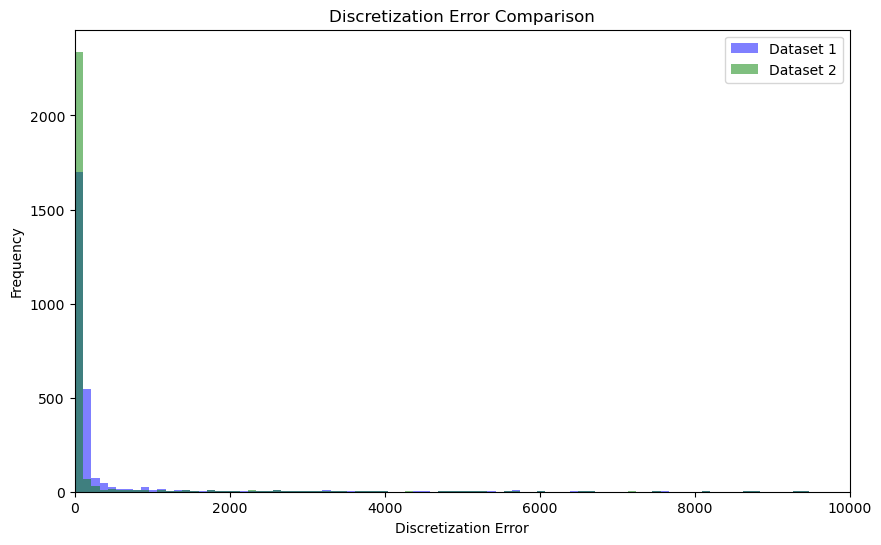

In [216]:
import numpy as np
from utils import helpers as h
from utils import settings as s
from analysis import analysis
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the necessary functions and classes are imported from 'analysis' and 'h'

# First Dataset -> Hoerl
Data1 = analysis.DataframeAnalysis()
Data1.load_df_from_csv(r'C:\Users\petre\Documents\GitHub\MATSimPipeline\output\20241230_183028\location_assignment_result_load_intermediate_hoerl.csv')
Data1.df = Data1.df[Data1.df['to_location'].notna()]
Data1.df = Data1.df[Data1.df['from_location'].notna()]
Data1.df['from_location'] = Data1.df['from_location'].apply(h.convert_to_point)
Data1.df['to_location'] = Data1.df['to_location'].apply(h.convert_to_point)
Data1.evaluate_distance_deviations_from_df()

# Second Dataset -> Advanced Petre 
Data2 = analysis.DataframeAnalysis()
Data2.load_df_from_csv(r'C:\Users\petre\Documents\GitHub\MATSimPipeline\output\20241230_183235\location_assignment_result_load_intermediate_advanced_petre_50-branches_30-min-cand-two-leg_10-min-cand-complex.csv')
Data2.df = Data2.df[Data2.df['to_location'].notna()]
Data2.df = Data2.df[Data2.df['from_location'].notna()]
Data2.df['from_location'] = Data2.df['from_location'].apply(h.convert_to_point)
Data2.df['to_location'] = Data2.df['to_location'].apply(h.convert_to_point)
Data2.evaluate_distance_deviations_from_df()



# Ensure the maximum value is limited to 1000
# Data1.df['discretization_error'] = Data1.df['discretization_error'].clip(upper=1000)
# Data2.df['discretization_error'] = Data2.df['discretization_error'].clip(upper=1000)
# 
# Data1.df.to_csv(r"C:\Users\petre\Documents\GitHub\MATSimPipeline\output\Hoerl.csv")
# Data2.df.to_csv(r"C:\Users\petre\Documents\GitHub\MATSimPipeline\output\Petre.csv")
# # Plotting in the same plot
plt.figure(figsize=(10, 6))

# Plot histogram for Dataset 1
Data1.df['discretization_error'].plot.hist(bins=100, alpha=0.5, color='blue', label='Dataset 1')

# Plot histogram for Dataset 2
Data2.df['discretization_error'].plot.hist(bins=100, alpha=0.5, color='green', label='Dataset 2')

# Adding title and labels
plt.title('Discretization Error Comparison')
plt.xlabel('Discretization Error')
plt.ylabel('Frequency')
plt.xlim(0, 10000)
plt.legend()

plt.show()


In [217]:
# Sum up discretization errors for each person
hoerl_errors = Data1.df.groupby('unique_person_id')['discretization_error'].sum().reset_index()
hoerl_errors.rename(columns={'discretization_error': 'hoerl_error'}, inplace=True)

advanced_petre_errors = Data2.df.groupby('unique_person_id')['discretization_error'].sum().reset_index()
advanced_petre_errors.rename(columns={'discretization_error': 'advanced_petre_error'}, inplace=True)

# Merge the summed errors for comparison
merged_df = hoerl_errors.merge(advanced_petre_errors, on='unique_person_id')

# Add the error ratio column
merged_df['error_ratio'] = merged_df['advanced_petre_error'] / merged_df['hoerl_error']

# Filter for cases where advanced Petre has a higher error than Hoerl
worse_cases = merged_df[merged_df['advanced_petre_error'] > merged_df['hoerl_error']]
worse_cases = worse_cases.sort_values(by='error_ratio', ascending=False)

# Filter for cases where advanced Petre has a lower error than Hoerl
better_cases = merged_df[merged_df['advanced_petre_error'] < merged_df['hoerl_error']]
better_cases = better_cases.sort_values(by='error_ratio')

# Filter for cases where advanced Petre and Hoerl have equal errors
equal_cases = merged_df[merged_df['advanced_petre_error'] == merged_df['hoerl_error']]

print(f"Better cases: {len(better_cases)}")
print(f"Worse cases: {len(worse_cases)}")
print(f"Equal cases: {len(equal_cases)}")

better_cases
# # Save the results
# worse_cases.to_csv('worse_cases.csv', index=False)
# better_cases.to_csv('better_cases.csv', index=False)
# equal_cases.to_csv('equal_cases.csv', index=False)

Better cases: 630
Worse cases: 1
Equal cases: 62


,unique_person_id,hoerl_error,advanced_petre_error,error_ratio
577,10569550_12093_10569552,152.570458,0.010480,0.000069
643,10643320_12156_10643321,729.232833,0.248800,0.000341
518,10496530_12030_10496533,350.717595,0.133738,0.000381
204,10202280_11760_10202283,255.206066,0.107403,0.000421
281,10260840_11823_10260841,298.265257,0.162385,0.000544
...,...,...,...,...
49,10060600_11611_10060603,126.634713,126.460833,0.998627
177,10181160_11735_10181161,10008.505856,9995.461240,0.998697
514,10493390_12026_10493392,5750.585316,5747.884182,0.999530
84,10085400_11641_10085402,5194.832015,5194.533343,0.999943


mean, median, plot deviation dist, the same per chain, -- capacity matching??

In [178]:
Data1.df[Data1.df["discretization_error"] > 14000]

,H_ID,H_GEW,H_HOCH,MODE,BASISAUF,TEILSTP,M_CAR,H_ART,H_GR,hhgr_gr,...,home_to_main_seconds,home_to_main_time_is_estimated,home_to_main_distance_is_estimated,to_activity_with_connected,home_location,from_location,to_location,to_act_identifier,placed_distance,discretization_error
925,1024880,2.281001,597.344642,3,1,1,1,2,2,2,...,600.0,0.0,0.0,errands,[ 555488.84761543 5808459.14444141],POINT (554654.49518631 5806712.51423235),POINT (554373.75995095 5810740.01128435),NaN,4037.26947,14962.73053


In [218]:
from analysis import plotting
plotting.plot_person_plan("10635930_12150_10635931", Data1.df, Data2.df)

In [219]:
Data1.df['discretization_error'].describe()

count     2663.000000
mean       378.121898
std       1148.387191
min          0.012455
25%         31.367853
50%         73.080766
75%        148.613862
max      10644.766780
Name: discretization_error, dtype: float64

In [220]:
Data2.df['discretization_error'].describe()


count     2663.000000
mean       267.555392
std       1091.745981
min          0.004719
25%          1.191919
50%          4.782691
75%         24.447311
max      10644.766780
Name: discretization_error, dtype: float64

In [211]:
# Filter df for a specific person
person_id = '10073530_11624_10073533'
person_df1 = Data1.df[Data1.df['unique_person_id'] == person_id]
person_df2 = Data2.df[Data2.df['unique_person_id'] == person_id]
person_df2

,H_ID,H_GEW,H_HOCH,MODE,BASISAUF,TEILSTP,M_CAR,H_ART,H_GR,hhgr_gr,...,home_to_main_seconds,home_to_main_time_is_estimated,home_to_main_distance_is_estimated,to_activity_with_connected,home_location,to_act_identifier,from_location,to_location,placed_distance,discretization_error
259,10073530,0.454169,118.937117,2,2,1,0,2,4,4,...,1650.0,1.0,1.0,work,[ 547230.45817282 5803523.41842474],2.379585e+08,POINT (547230.45817282 5803523.41842474),POINT (553932.79184006 5811139.34682218),10145.128976,540.585310
260,10073530,0.454169,118.937117,2,2,1,0,2,4,4,...,1650.0,1.0,1.0,return_journey,[ 547230.45817282 5803523.41842474],1.628318e+09,POINT (553932.79184006 5811139.34682218),POINT (556930.67585174 5795768.32784297),15660.636418,2260.792154
261,10073530,0.454169,118.937117,2,2,1,0,2,4,4,...,1650.0,1.0,1.0,leisure,[ 547230.45817282 5803523.41842474],8.084981e+08,POINT (556930.67585174 5795768.32784297),POINT (554461.0410041 5802100.20238781),6796.449921,39.307064
262,10073530,0.454169,118.937117,2,2,1,0,2,4,4,...,1650.0,1.0,1.0,home,[ 547230.45817282 5803523.41842474],NaN,POINT (554461.0410041 5802100.20238781),POINT (547230.45817282 5803523.41842474),7369.319641,283.605355


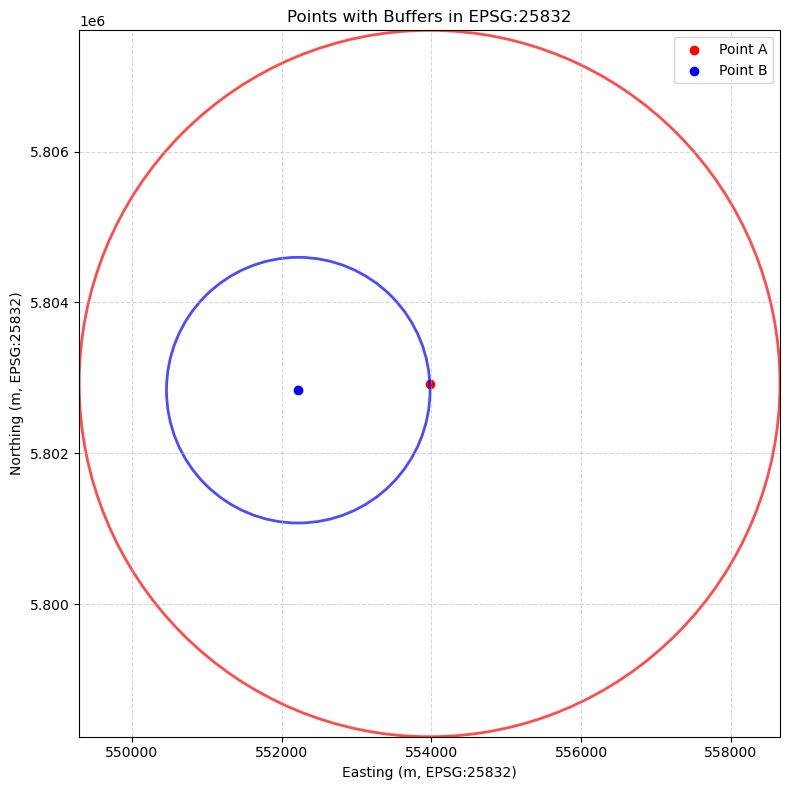

In [28]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Given coordinates and radii
xA, yA = 553974.57860439, 5802925.60509337
xB, yB = 552220.91668614, 5802837.50039429

radius_A = 4680.0
radius_B = 1760.0

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the points
ax.scatter([xA], [yA], color='red', label='Point A')
ax.scatter([xB], [yB], color='blue', label='Point B')

# Add circles (buffers) around the points
circleA = Circle((xA, yA), radius=radius_A, edgecolor='red', facecolor='none', linewidth=2, alpha=0.7)
circleB = Circle((xB, yB), radius=radius_B, edgecolor='blue', facecolor='none', linewidth=2, alpha=0.7)
ax.add_patch(circleA)
ax.add_patch(circleB)

# Adjust the plot view so both points and circles are visible
# Determine min and max extents by considering the outer boundaries of the largest circle
min_x = min(xA - radius_A, xB - radius_B)
max_x = max(xA + radius_A, xB + radius_B)
min_y = min(yA - radius_A, yB - radius_B)
max_y = max(yA + radius_A, yB + radius_B)

ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)

# Add grid and legend for clarity
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()

# Add labels
ax.set_xlabel('Easting (m, EPSG:25832)')
ax.set_ylabel('Northing (m, EPSG:25832)')
ax.set_title('Points with Buffers in EPSG:25832')

# Show the plot
plt.tight_layout()
plt.show()


In [41]:
Mid=pd.read_csv(r"C:\Users\petre\Documents\GitHub\MATSimPipeline\data\mid\enhanced\enhanced_mid.csv")
# show the col km_routing and wegkm_imp
# Mid = Mid[Mid['etapkm'] < 1000]
Mid[['km_routing', 'wegkm','wegkm_imp', 'etapkm', 'W_ZWECK', 'hvm']]

,km_routing,wegkm,wegkm_imp,etapkm,W_ZWECK,hvm
0,216.420,0.95,0.95,10107.0,4.0,4.0
1,216.419,1.43,1.43,10107.0,8.0,4.0
2,9995.000,10.45,10.45,10107.0,7.0,4.0
3,9995.000,7.60,7.60,10107.0,8.0,4.0
4,9995.000,13.30,13.30,10107.0,4.0,4.0
...,...,...,...,...,...,...
957009,70706.000,0.98,0.98,10107.0,1.0,2.0
957010,70706.000,0.98,0.98,10107.0,4.0,2.0
957011,70706.000,0.98,0.98,10107.0,8.0,2.0
957012,24.906,18.00,18.00,10107.0,7.0,5.0


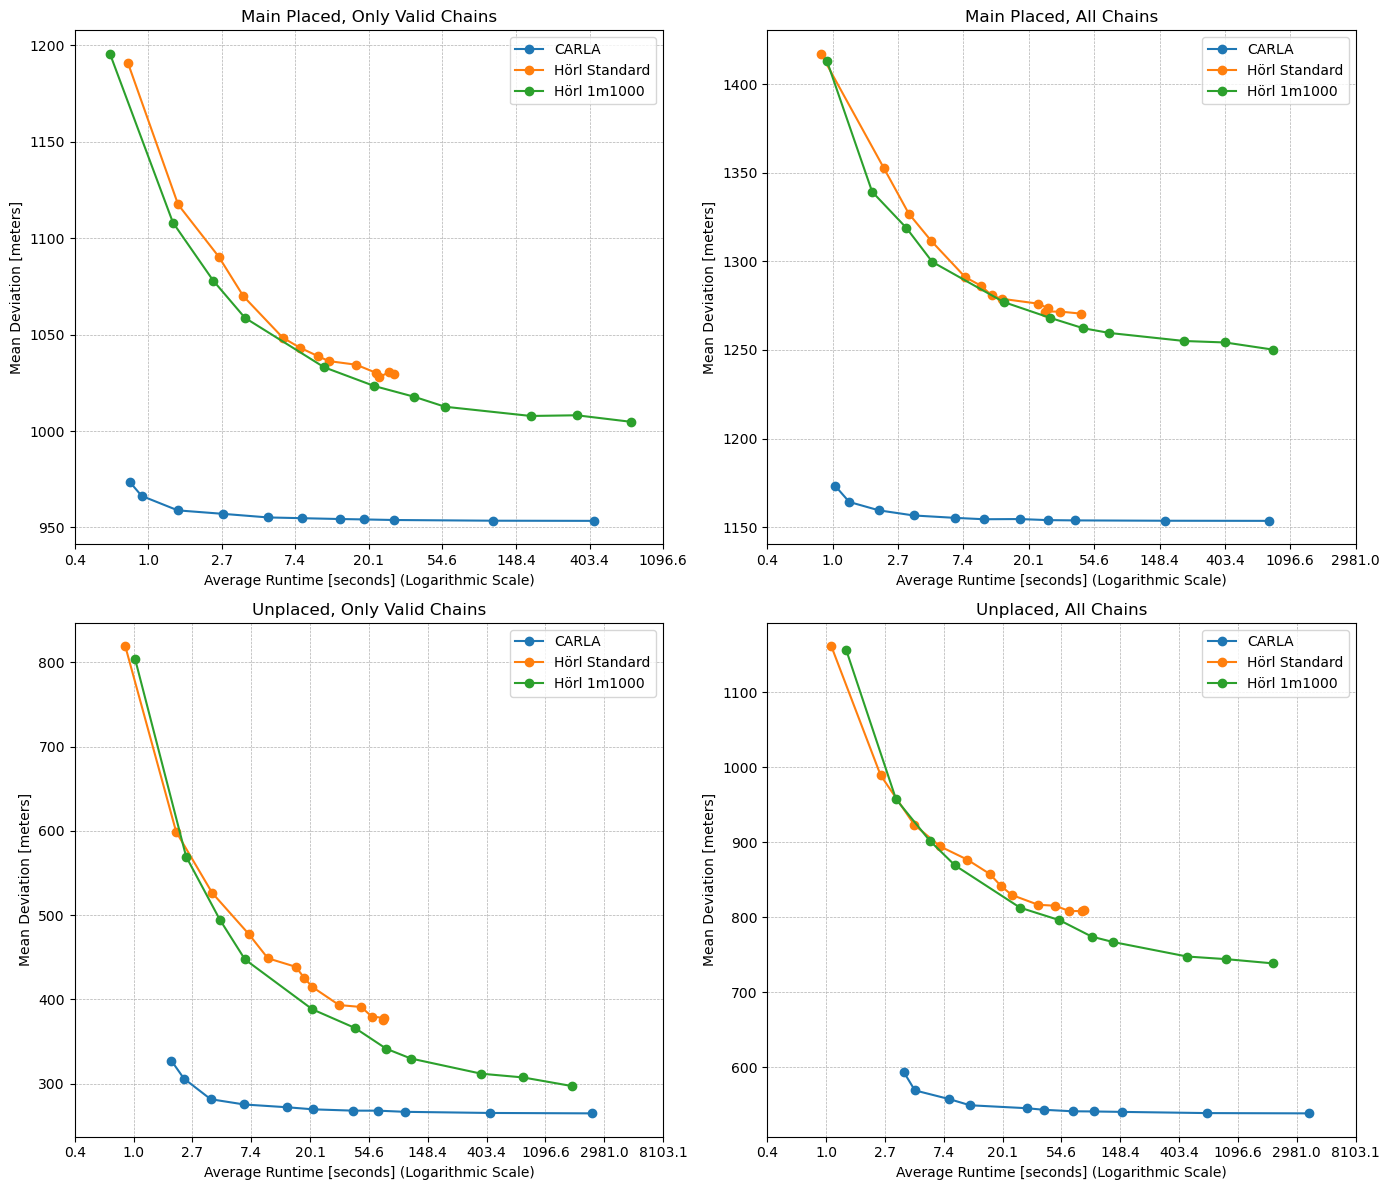

In [228]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# File paths
base_path = r"C:\Users\petre\Documents\GitHub\MATSimPipeline\analysis\analysis_data"
file_paths = {
    "onlyvalidmainplaced_hoerl_standard": os.path.join(base_path, "onlyvalidmainplaced_hoerl_standard.csv"),
    "onlyvalidmainplaced_hoerl_1m1000": os.path.join(base_path, "onlyvalidmainplaced_hoerl_1m1000.csv"),
    "onlyvalidmainplaced_petre": os.path.join(base_path, "onlyvalidmainplaced_petre.csv"),
    "invalidandvalidmainplaced_hoerl_standard": os.path.join(base_path, "invalidandvalidmainplaced_hoerl_standard.csv"),
    "invalidandvalidmainplaced_hoerl_1m1000": os.path.join(base_path, "invalidandvalidmainplaced_hoerl_1m1000.csv"),
    "invalidandvalidmainplaced_petre": os.path.join(base_path, "invalidandvalidmainplaced_petre.csv"),
    "onlyvalidmainandopenunplaced_hoerl_standard": os.path.join(base_path, "onlyvalidmainandopenunplaced_hoerl_standard.csv"),
    "onlyvalidmainandopenunplaced_hoerl_1m1000": os.path.join(base_path, "onlyvalidmainandopenunplaced_hoerl_1m1000.csv"),
    "onlyvalidmainandopenunplaced_petre": os.path.join(base_path, "onlyvalidmainandopenunplaced_petre.csv"),
    "invalidandvalidmainandopenunplaced_hoerl_std": os.path.join(base_path, "Invalidandvalidmainandopenunplaced_hoerl_std.csv"),
    "invalidandvalidmainandopenunplaced_hoerl_1m1000": os.path.join(base_path, "Invalidandvalidmainandopenunplaced_hoerl_1m1000.csv"),
    "invalidandvalidmainandopenunplaced_petre": os.path.join(base_path, "Invalidandvalidmainandopenunplaced_petre.csv"),
}

# Load data into DataFrames
dataframes = {name: pd.read_csv(path) for name, path in file_paths.items()}

# Organize datasets into the four combinations
combined_datasets = {
    "Placed & Only Valid": {
        "CARLA": dataframes.get("onlyvalidmainplaced_petre"),
        "Hörl Standard": dataframes.get("onlyvalidmainplaced_hoerl_standard"),
        "Hörl 1m1000": dataframes.get("onlyvalidmainplaced_hoerl_1m1000"),
    },
    "Placed & Valid and Unvalid Combined": {
        "CARLA": dataframes.get("invalidandvalidmainplaced_petre"),
        "Hörl Standard": dataframes.get("invalidandvalidmainplaced_hoerl_standard"),
        "Hörl 1m1000": dataframes.get("invalidandvalidmainplaced_hoerl_1m1000"),
    },
    "Unplaced & Only Valid": {
        "CARLA": dataframes.get("onlyvalidmainandopenunplaced_petre"),
        "Hörl Standard": dataframes.get("onlyvalidmainandopenunplaced_hoerl_standard"),
        "Hörl 1m1000": dataframes.get("onlyvalidmainandopenunplaced_hoerl_1m1000"),
    },
    "Unplaced & Valid and Unvalid Combined": {
        "CARLA": dataframes.get("invalidandvalidmainandopenunplaced_petre"),
        "Hörl Standard": dataframes.get("invalidandvalidmainandopenunplaced_hoerl_std"),
        "Hörl 1m1000": dataframes.get("invalidandvalidmainandopenunplaced_hoerl_1m1000"),
    },
}

# Remove the very first value for all Hörl data
for combination, data in combined_datasets.items():
    for method in ["Hörl Standard", "Hörl 1m1000"]:
        if data.get(method) is not None:
            data[method] = data[method].iloc[1:]  # Exclude the first row

# Titles for each plot
titles = [
    "Main Placed, Only Valid Chains",
    "Main Placed, All Chains",
    "Unplaced, Only Valid Chains",
    "Unplaced, All Chains",
]

# Plot the four cases in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, (combination, data) in enumerate(combined_datasets.items()):
    ax = axes[i]
    for method, df in data.items():
        if df is not None:
            if method == "CARLA":
                # Filter Petre data to include only the "number_of_branches" parameter
                df = df[df["param"].str.contains("number_of_branches")]
            if not df.empty:
                x = df["average_runtime"]
                y = df["mean_quality"]
                # Plot both line and points
                ax.plot(
                    np.log(x),
                    y,
                    label=f"{method}",  # Customizable legend labels
                    linestyle="-",
                    marker="o",
                )
    ax.set_title(titles[i])
    ax.set_xlabel("Average Runtime [seconds] (Logarithmic Scale)")
    ax.set_ylabel("Mean Deviation [meters]")  # Custom y-axis label
    # Set x-ticks to actual runtimes in seconds
    x_ticks = ax.get_xticks()
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([f"{np.exp(tick):.1f}" for tick in x_ticks])
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax.legend()

# Adjust layout for clarity
plt.tight_layout()
plt.show()
